# Testing MART with IRIS data
My experimentation in the [SimplePlaid notebook](SimplePlaid.ipynb) showed that the _Smooth_ part of my ancient SMART algorithm, and its complicated control law, were quite unnecessary. I now have a simple and streamlined vanilla MART. Now, however, a number of things have to be worked out before MART reaches its full potential.
1. Can I improve results by increasing contrast to minimize the entropy? There are persistent hints that some such regularization scheme might help, but results with very fake test targets may not give the insight I really need. My crude attempts at regularization so far have been dismal failures.
2. What initial guess should I use? I experimented with that years ago, and found a strong prior for the line core was helpful.

I have stored Roy's IRIS training dataset (retrieved December, 2018) as `roy-iris-cube.pickle`. Below I experiment with slice 175, containing an explosive event that I have dubbed the Crucifix. This potentially clarifies some of the above questions and adds some more:
3. Starting with an initial guess that looks kind of like $I_{\infty}$, a tight line core with some background, not only improves the result but gives more rapid convergence by a factor of 10.
4. Just guessing, but I suspect the residuals are much worse in the neighborhood of the EEs at approx. $x=25$ and $x=65$. I hypothesize that  a position-dependent, rather than a global, goodness of fit would be worth putting into MART.

In [1]:
# Load Roy's data cube
import pickle
infile = open('roy-iris-cube.pickle','rb')
cube = pickle.load(infile)
infile.close()
print('cube shape: ',cube.shape)

cube shape:  (1831, 200, 21, 1)


In [2]:
# Example: the crucifix
import numpy as np
import moses
import matplotlib.pyplot as plt
Npad = 3 # for padding in the lambda direction
ExplosiveEvent0 =   33 # first index of cube, to get an alternative explosive event.
ExplosiveEvent1 =  121 # first index of cube, to get an alternative explosive event.
ExplosiveEvent2 =  175 # first index of cube, to get the 'crucifix' explosive event. *** my favorite.
ExplosiveEvent3 = 1015 # first index of cube, to get an alternative explosive event.
I = moses.zpad(cube[ExplosiveEvent2,:,:,0], Npad)
    # Different slices of the cube can be tried by replacing the first index to get
    # any slice in the cube. The above explosive events are particularly useful examples.
I = (I + np.abs(I))/2
print('I shape: ',I.shape)
print('I min mean max = ',np.amin(I),np.mean(I),np.amax(I))
Nx = I.shape[0]
Nlambda = I.shape[1]
j0 = int(np.floor(Nlambda/2.))

I shape:  (200, 27)
I min mean max =  0.0 18.201157407407408 450.25


In [3]:
# Calculate data with Poisson noise
import moses
I *= 10 # more counts
Dp = np.random.poisson(moses.fomod(I, 1,j0)).astype(float)
D0 = np.random.poisson(moses.fomod(I, 0,j0)).astype(float)
Dm = np.random.poisson(moses.fomod(I,-1,j0)).astype(float)
print('Crucifix mean signal = ',np.mean(Dp))

# Simple MART
DataArr = np.array([D0,Dp,Dm])
mArr = np.array([0,1,-1])
Gmart = moses.mart(DataArr, mArr, Nlambda, j0, maxiter=3000)

Crucifix mean signal =  4916.665
outeration  1  of, at most,  1
MART iteration  1  of, at most,  3000
0  order "reduced chisquare" =  3956.3510154332366
1  order "reduced chisquare" =  738.487513687336
-1  order "reduced chisquare" =  560.3694633309664
MART iteration  2  of, at most,  3000
0  order "reduced chisquare" =  86.96981783485626
1  order "reduced chisquare" =  54.921225582575765
-1  order "reduced chisquare" =  66.76499092400807
MART iteration  3  of, at most,  3000
0  order "reduced chisquare" =  38.41113061233728
1  order "reduced chisquare" =  20.703070702481458
-1  order "reduced chisquare" =  22.53161666499729
MART iteration  4  of, at most,  3000
0  order "reduced chisquare" =  28.580585962284328
1  order "reduced chisquare" =  13.396109654663388
-1  order "reduced chisquare" =  13.703796507321629
MART iteration  5  of, at most,  3000
0  order "reduced chisquare" =  23.90942344273372
1  order "reduced chisquare" =  10.302880562128985
-1  order "reduced chisquare" =  10.

-1  order "reduced chisquare" =  1.0554392953259133
MART iteration  75  of, at most,  3000
0  order "reduced chisquare" =  3.212884095528842
1  order "reduced chisquare" =  1.0248450778906248
-1  order "reduced chisquare" =  1.0377390367944315
MART iteration  76  of, at most,  3000
0  order "reduced chisquare" =  3.1607459880094906
1  order "reduced chisquare" =  1.0078928719519737
-1  order "reduced chisquare" =  1.0204092120692891
MART iteration  77  of, at most,  3000
0  order "reduced chisquare" =  3.1096339231134187
1  order "reduced chisquare" =  0.9912852047379596
-1  order "reduced chisquare" =  1.8050312764142837
MART iteration  78  of, at most,  3000
0  order "reduced chisquare" =  1.8901271303255271
1  order "reduced chisquare" =  1.7176977138503147
-1  order "reduced chisquare" =  0.6250264701914355
MART iteration  79  of, at most,  3000
0  order "reduced chisquare" =  1.4793090074514519
1  order "reduced chisquare" =  1.2816599897470504
-1  order "reduced chisquare" =  1.1

In [4]:
# Give simple MART a better start?
G_initial = moses.window((Nx,Nlambda))**40 + 0.05 # Line core plus background
GmartPrecon = moses.mart(DataArr, mArr, Nlambda, j0, maxiter=2000, InitGuess=G_initial, LGOF=False)

outeration  1  of, at most,  1
MART iteration  1  of, at most,  2000
0  order "reduced chisquare" =  6983382.62639587
1  order "reduced chisquare" =  45482.618498029056
-1  order "reduced chisquare" =  3817.504727133035
MART iteration  2  of, at most,  2000
0  order "reduced chisquare" =  490.4228072648522
1  order "reduced chisquare" =  70.80112844769346
-1  order "reduced chisquare" =  71.21122725511975
MART iteration  3  of, at most,  2000
0  order "reduced chisquare" =  41.245865355126334
1  order "reduced chisquare" =  8.36833982637021
-1  order "reduced chisquare" =  24.988055312639535
MART iteration  4  of, at most,  2000
0  order "reduced chisquare" =  17.339585957469662
1  order "reduced chisquare" =  2.9856313596501876
-1  order "reduced chisquare" =  10.76923152418733
MART iteration  5  of, at most,  2000
0  order "reduced chisquare" =  8.113426287290121
1  order "reduced chisquare" =  1.6789156516367414
-1  order "reduced chisquare" =  5.235706590333105
MART iteration  6  o

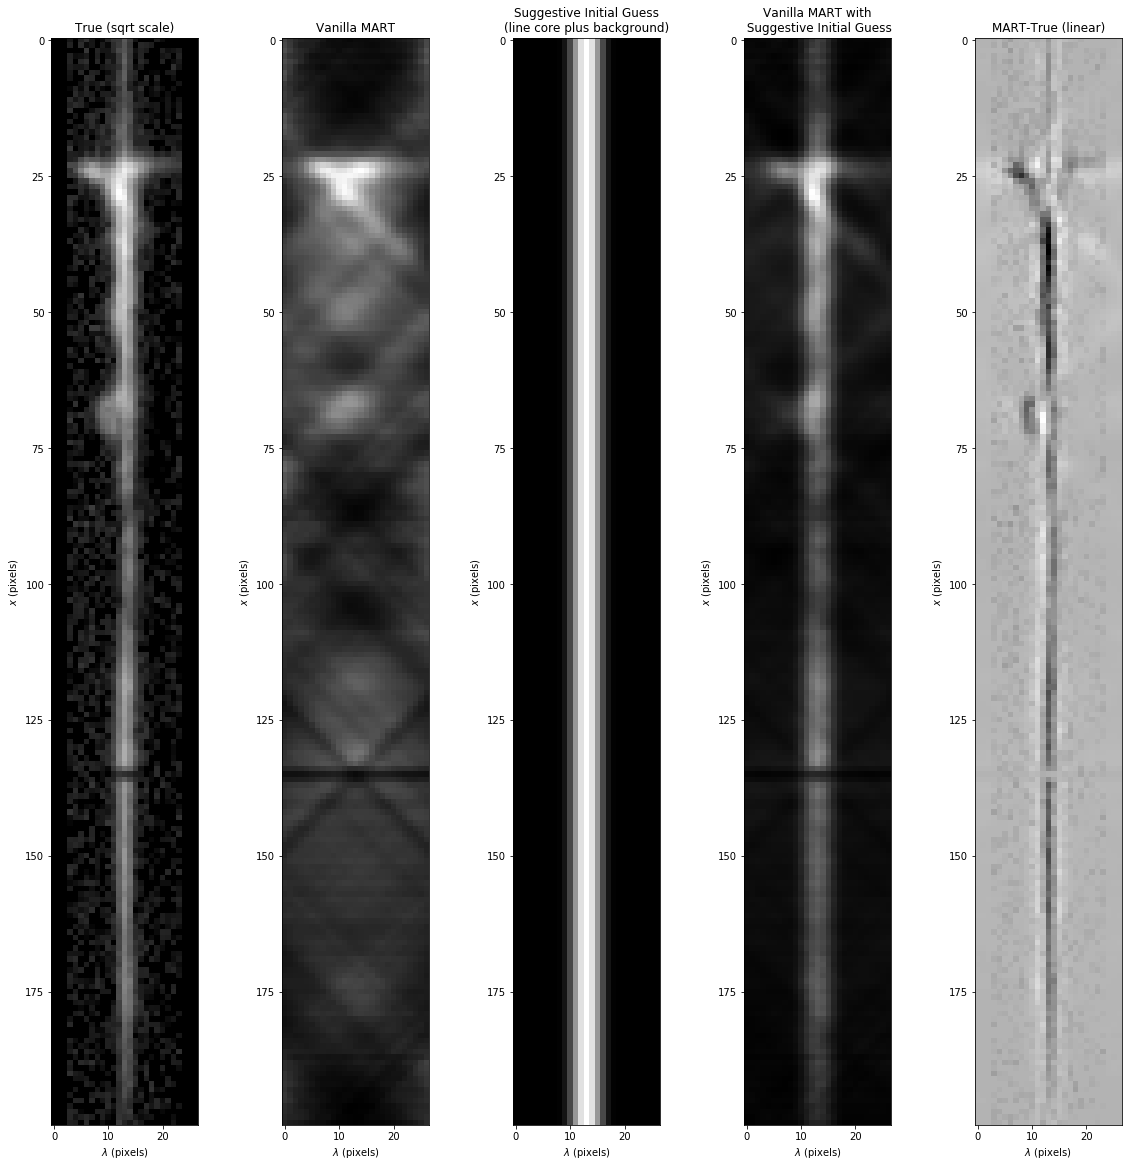

In [5]:
# Plot the 'true' image, I
plt.figure(figsize=(20,20))
ax = plt.subplot(151)
plot = plt.imshow(np.sqrt(I))
plt.xlabel('$\lambda$ (pixels)')
plt.ylabel('$x$ (pixels)')
plt.title('True (sqrt scale)')
plot.set_cmap('gray')

# Plot the vanilla MART result
ax = plt.subplot(152)
plot = plt.imshow(np.sqrt(Gmart))
plt.xlabel('$\lambda$ (pixels)')
plt.ylabel('$x$ (pixels)')
plt.title('Vanilla MART')
plot.set_cmap('gray')


# Plot the initial guess
ax = plt.subplot(153)
plot = plt.imshow(np.sqrt(G_initial))
plt.xlabel('$\lambda$ (pixels)')
plt.ylabel('$x$ (pixels)')
plt.title('Suggestive Initial Guess\n(line core plus background)')
plot.set_cmap('gray')


# Plot the preconditioned MART result
ax = plt.subplot(154)
plot = plt.imshow(np.sqrt(GmartPrecon))
plt.xlabel('$\lambda$ (pixels)')
plt.ylabel('$x$ (pixels)')
plt.title('Vanilla MART with\n Suggestive Initial Guess')
plot.set_cmap('gray')

# Plot the difference
ax = plt.subplot(155)
plot = plt.imshow(GmartPrecon-I)
plt.xlabel('$\lambda$ (pixels)')
plt.ylabel('$x$ (pixels)')
plt.title('MART-True (linear)')
plot.set_cmap('gray')



### Discussion
The the linewidth of the initial guess and the magnitude of the background influence the result significantly. I have tuned these parameters to get a good looking result. There are obvious errors like the suppression of the line broadening and doppler shift at $65<x<75$.

## Local Goodness-of-Fit?
In point 4, I noted that my "$\chi^2$" is a global measure of goodness-of-fit. I guessed that MART might not bother to fit the explosive events well because they don't contribute that much to the global picture in each order. Let's see if that is correct.

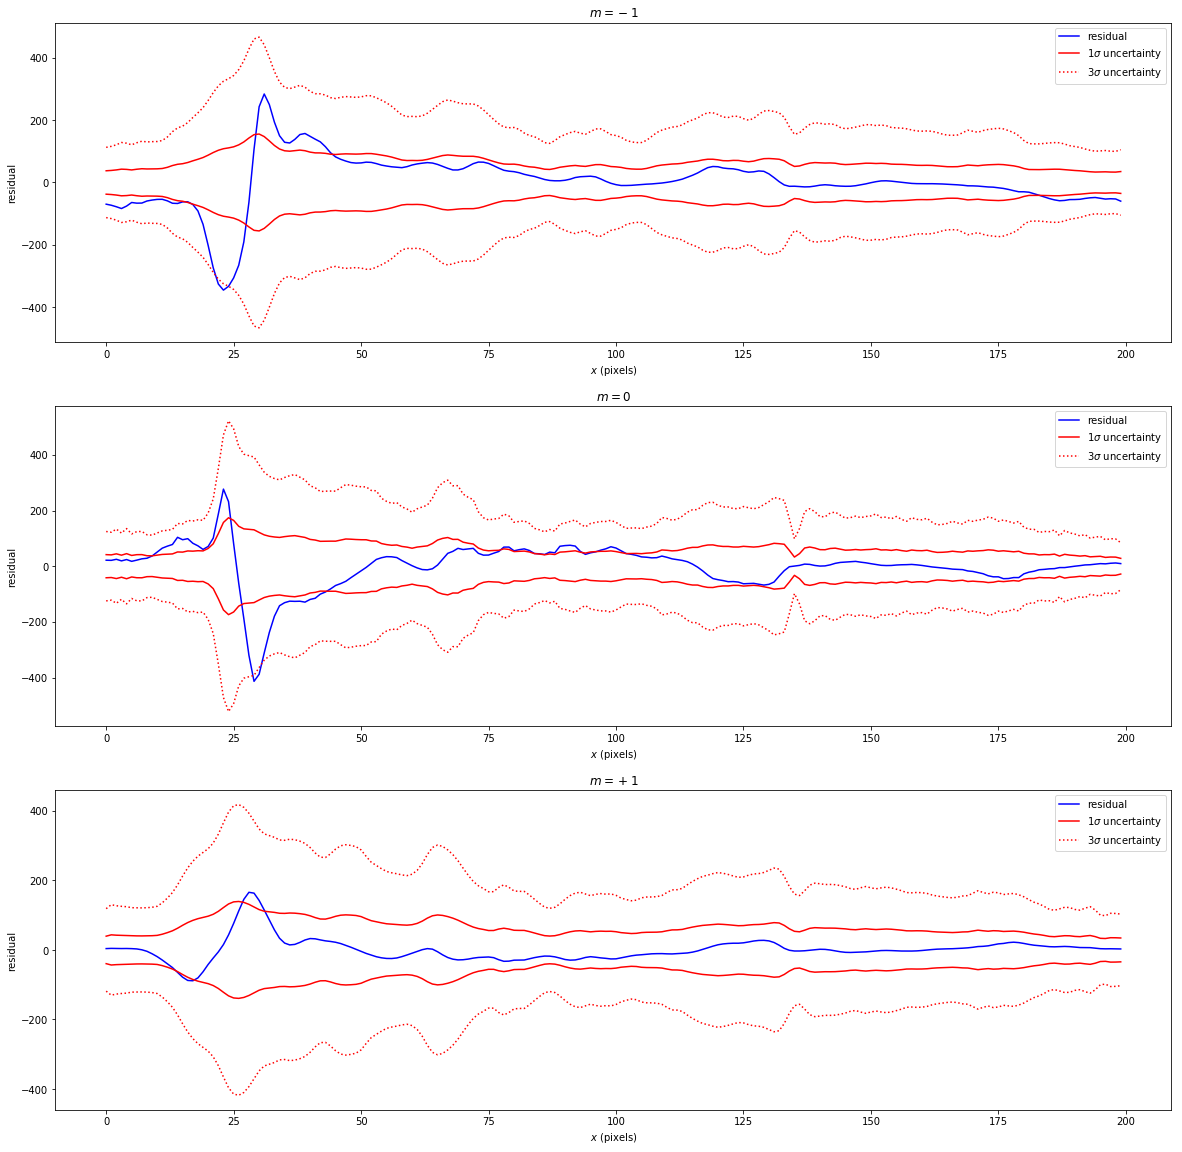

In [6]:
# Was I right about residuals?
# Projections through the inversion, GmartPrecon:
DGm = moses.fomod(GmartPrecon, -1,j0)
DG0 = moses.fomod(GmartPrecon,  0,j0)
DGp = moses.fomod(GmartPrecon, +1,j0)

# MART works from anti-aliased outboard orders. Therefore,
# I create anti-aliased versions of the outboard orders for
# honest comparison with the corresponding projections
# through the inversion (DGm and DGp):
Dm_aa = moses.antialias(Dm)
Dp_aa = moses.antialias(Dp)

#Plot residuals
plt.figure(figsize=(20,20))
ax = plt.subplot(311)
plt.plot(Dm_aa-DGm,'b',label='residual')
plt.plot(np.sqrt(DGm),'r',label='$1\sigma$ uncertainty')
plt.plot(-np.sqrt(DGm),'r')
plt.plot(3*np.sqrt(DGm),'r:',label='$3\sigma$ uncertainty')
plt.plot(-3*np.sqrt(DGm),'r:')
plt.xlabel('$x$ (pixels)')
plt.ylabel('residual')
plt.title('$m=-1$')
plt.legend()

ax = plt.subplot(312)
plt.plot(D0-DG0,'b',label='residual')
plt.plot(np.sqrt(DG0),'r',label='$1\sigma$ uncertainty')
plt.plot(-np.sqrt(DG0),'r')
plt.plot(3*np.sqrt(DG0),'r:',label='$3\sigma$ uncertainty')
plt.plot(-3*np.sqrt(DG0),'r:')
plt.xlabel('$x$ (pixels)')
plt.ylabel('residual')
plt.title('$m=0$')
plt.legend()

ax = plt.subplot(313)
plt.plot(Dp_aa-DGp,'b',label='residual')
plt.plot(np.sqrt(DGp),'r',label='$1\sigma$ uncertainty')
plt.plot(-np.sqrt(DGp),'r')
plt.plot(3*np.sqrt(DGp),'r:',label='$3\sigma$ uncertainty')
plt.plot(-3*np.sqrt(DGp),'r:')
plt.xlabel('$x$ (pixels)')
plt.ylabel('residual')
plt.title('$m=+1$')
plt.legend()

plt.show();

### Discussion
The global goodness-of-fit fails to enforce a good fit across the whole dataset. In fact, the explosive event residuals are up to $\sim 3\sigma$, varying from run to run. This tends to support my hypothesis. 


__I have rewritten `moses.mart` use a local goodness-of-fit measure. This does not seem to result in better spectral recovery, but at least now I know that I am taking better advantage of the data in places that are difficult ot fit. The improvement can be seen by setting `LGOF=True` in the inversion for `GmartPrecon`.__

A few words are in order regarding the current version of `moses.mart`. 
1. `LGOF=False` is the default.
1. LGOF definitely works. But as you might expect, with such localized attention to residuals, a lot of the residuals with `LGOF=True` are at exactly $1\sigma$, which doesn't seem quite natural. 
1. I have a first MART loop that still uses global goodness-of-fit. The LGOF loop is run after that, optionally. This seems to slightly ameliorate the above problem, and I think it does no harm.
1. I have increased the convergence rate a bit by doubling the exponent on the correction factor. This also helps to make the residuals look more 'noisy', hence more natural.
1. Anti-aliasing of the inputs is farmed out to a separate routine, `moses.antialias`, which makes it convenient to generate anti-aliased data arrays for honest comparison to projections through the inverted cube.
1. The examples in [Simple Plaid](SimplePlaid.ipynb) are not affected noticeably by the changes.

In [9]:
# Craft a very simple initial guess
InitGuess = moses.window((Nx,Nlambda))**2 # Precondition as a broad, bell-shaped window 
InitGuess = moses.mart(DataArr, mArr, Nlambda, j0, InitGuess=InitGuess, 
                      maxiter=3000, Verbose=False)

# Regularized inversion, maximizing "negentropy"
GmartNegentropy = moses.mart(DataArr, mArr, Nlambda, j0, InitGuess=InitGuess,
                      Filter=moses.contrast_smooth, Maximize=moses.negentropy, 
                      maxiter=3000, maxouter=150, Verbose=False)


outeration  1  of, at most,  1
Maximize(Guess) =  -4.619999801911876
outeration  1  of, at most,  150
Maximize(Guess) =  -4.646295520933092
outeration  2  of, at most,  150
Maximize(Guess) =  -4.670590422699938
outeration  3  of, at most,  150
Maximize(Guess) =  -4.691903573932737
outeration  4  of, at most,  150
Maximize(Guess) =  -4.711504580456279
outeration  5  of, at most,  150
Maximize(Guess) =  -4.7267657453539895
outeration  6  of, at most,  150
Maximize(Guess) =  -4.7368641040573705
outeration  7  of, at most,  150
Maximize(Guess) =  -4.743771566609352
outeration  8  of, at most,  150
Maximize(Guess) =  -4.743832832218745
outeration  9  of, at most,  150
Maximize(Guess) =  -4.7470694317385105
outeration  10  of, at most,  150
Maximize(Guess) =  -4.740613583613765
outeration  11  of, at most,  150
Maximize(Guess) =  -4.714200155474549
outeration  12  of, at most,  150
Maximize(Guess) =  -4.674739093479297
outeration  13  of, at most,  150
Maximize(Guess) =  -4.6204515034539435


Maximize(Guess) =  -3.2768616763457143
outeration  119  of, at most,  150
Maximize(Guess) =  -3.2770309374945255
outeration  120  of, at most,  150
Maximize(Guess) =  -3.2768485207545583
outeration  121  of, at most,  150
Maximize(Guess) =  -3.2772203117504404
outeration  122  of, at most,  150
Maximize(Guess) =  -3.277020629251802
outeration  123  of, at most,  150
Maximize(Guess) =  -3.2772058617973197
outeration  124  of, at most,  150
Maximize(Guess) =  -3.2772568012887446
outeration  125  of, at most,  150
Maximize(Guess) =  -3.2773904173865707
outeration  126  of, at most,  150
Maximize(Guess) =  -3.2771839483643803
outeration  127  of, at most,  150
Maximize(Guess) =  -3.2771415515524582
outeration  128  of, at most,  150
Maximize(Guess) =  -3.2758252687667175
outeration  129  of, at most,  150
Maximize(Guess) =  -3.2764019920543017
outeration  130  of, at most,  150
Maximize(Guess) =  -3.276023322045591
outeration  131  of, at most,  150
Maximize(Guess) =  -3.2751374295736926
o

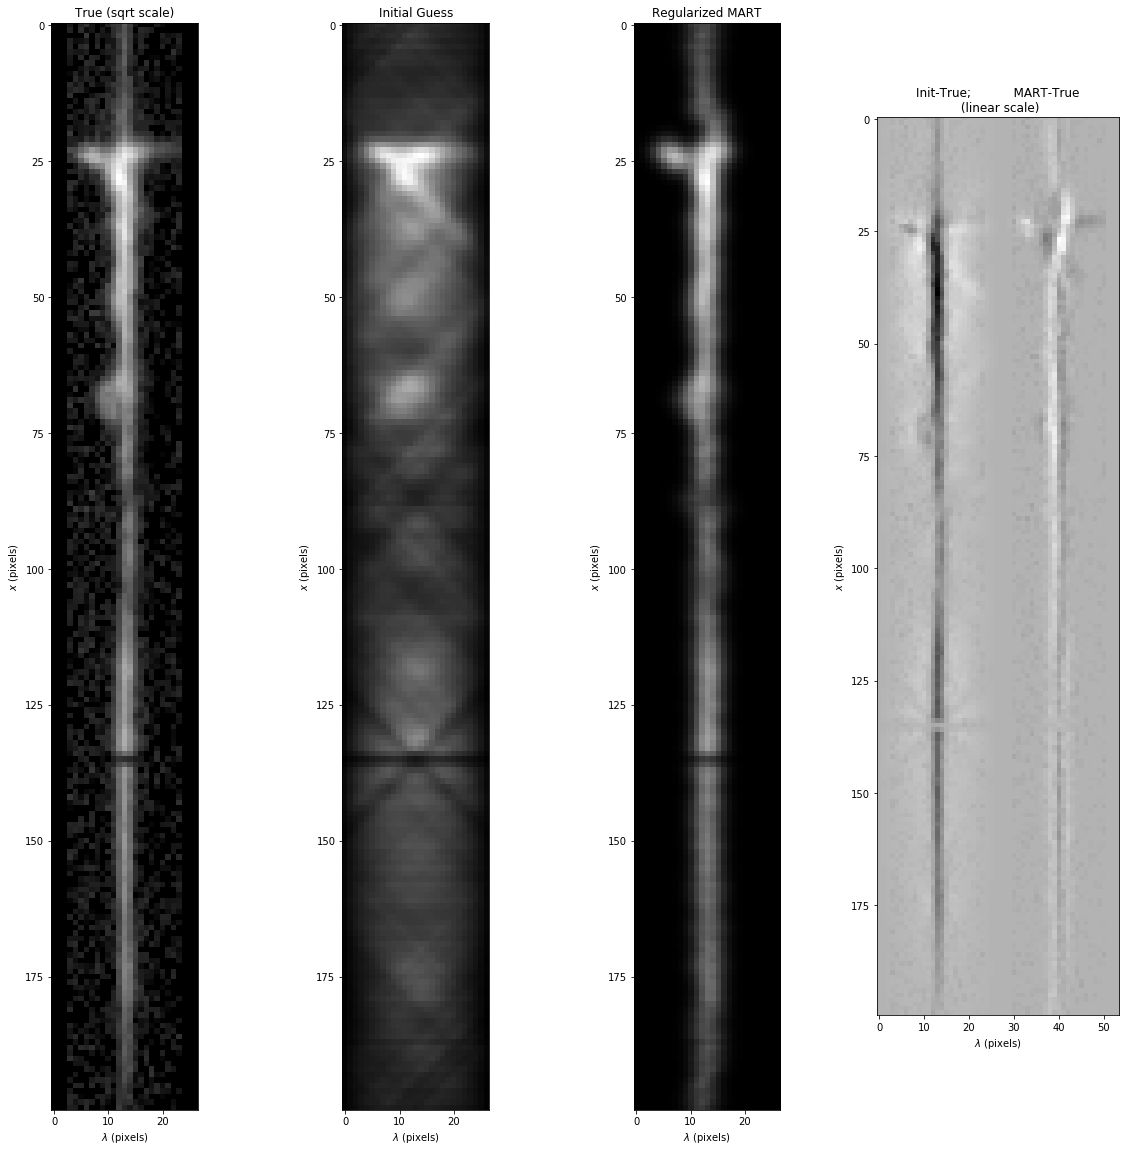

In [8]:
# Plot the 'true' image, I
plt.figure(figsize=(20,20))
ax = plt.subplot(141)
plot = plt.imshow(np.sqrt(I))
plt.xlabel('$\lambda$ (pixels)')
plt.ylabel('$x$ (pixels)')
plt.title('True (sqrt scale)')
plot.set_cmap('gray')

# Plot the initial guess
ax = plt.subplot(142)
plot = plt.imshow(np.sqrt(InitGuess))
plt.xlabel('$\lambda$ (pixels)')
plt.ylabel('$x$ (pixels)')
plt.title('Initial Guess')
plot.set_cmap('gray')


# Plot the regularized MART result
ax = plt.subplot(143)
plot = plt.imshow(np.sqrt(GmartNegentropy))
plt.xlabel('$\lambda$ (pixels)')
plt.ylabel('$x$ (pixels)')
plt.title('Regularized MART')
plot.set_cmap('gray')

# Plot the difference
ax = plt.subplot(144)
plot = plt.imshow(np.concatenate( (InitGuess-I, GmartNegentropy-I), axis=1))
plt.xlabel('$\lambda$ (pixels)')
plt.ylabel('$x$ (pixels)')
plt.title('Init-True;           MART-True\n (linear scale)')
plot.set_cmap('gray')



### Discussion
1. I have obtained a reasonably smooth result with minimized entropy using a regularization scheme similar to that developed for [the Simple Plaid notebook](SimplePlaid.ipynb). 
1. The regularization takes a lot of outeration loops to find the lowest entropy. I tried to make it faster by using a bigger contrast power $p$ in the filter, but the resulting increase in _iterations_ required for MART to converge seems to more than make up for the savings in _outerations_.
1. I added iterative smoothing into the filter (`moses.contrast_smooth`) to avoid shrinking the line profile to a single pixel and/or getting strong spatial discontinuities.
1. The amount of smoothing is arbitrary, and it does matter, so this constitutes a new adjustable parameter.
1. __This regularization eliminates the plaid successfully. Hurray!__
1. Broadening at $65<x<75$ appears marginally improved compared to `GmartPrecon`, but the residuals may be a little larger.
1. Fit to the EE at $x \sim 25$ is markedly worse than `GmartPrecon`. 
1. `LGOF` is off (by default), to save iterations. Turning it on doesn't make a noticeable difference in the result.
1. Results are similar with other explosive events, which can easily be subbed in to this notebook.
